In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 연습 - 
supervised learning problem 형태로 데이터 바꾸기

In [24]:
df = pd.DataFrame(x for x in range(10))
raw = []

for i in range(1, 0, -1):
    raw.append(df.shift(i))

for i in range(0, 1):
    raw.append(df.shift(-i))

sum = pd.concat(raw, axis=1)
sum.dropna(inplace=True)
sum

,0,0
1,0.0,1
2,1.0,2
3,2.0,3
4,3.0,4
5,4.0,5
6,5.0,6
7,6.0,7
8,7.0,8
9,8.0,9


# 주식 데이터 수정종가만 사용

In [3]:
# 데이터 불러오기
df = pd.read_csv('./data/기아_sample.csv')

In [6]:
df

,code,date,open,high,low,close,diff,volume
0,270,2008-01-02,10050,10150,9960,9960,140,1281211
1,270,2008-01-03,9900,10100,9870,10050,90,1217977
2,270,2008-01-04,10150,10150,9960,9970,80,1041673
3,270,2008-01-07,9900,10100,9820,9940,30,1377968
4,270,2008-01-08,10050,10150,9860,9890,50,2095085
...,...,...,...,...,...,...,...,...
3693,270,2022-12-08,65200,65300,64500,64700,300,1271219
3694,270,2022-12-09,65100,65500,64700,65200,500,1011844
3695,270,2022-12-12,65100,65600,65000,65100,100,687218
3696,270,2022-12-13,65300,65500,62100,62500,2600,3121687


In [7]:
# df = df[['date', 'close']]
values = df['close'].values

In [8]:
df2 = df[['code', 'date', 'open', 'high', 'low']]

In [9]:
# time series 데이터를 supervised learning 데이터로 변형

# 10일치의 데이터 입력하고 다음날 하루의 종가 정보 예측
days_in = 10
day_out = 1

df = pd.DataFrame(values)
raw = []

# 10개씩 덩어리로 자르기
for i in range(days_in, 0, -1):
    raw.append(df.shift(i))

for i in range(0, day_out):
    raw.append(df.shift(-i))

sum = pd.concat(raw, axis=1)
sum.dropna(inplace=True)

# row로는 날짜, column은 10일간의 종가들이 들어가고, 마지막 열인 11열을 타겟컬럼으로 설정



In [11]:
# 종가가 10일별로 밑으로 
train = sum.values

In [12]:
# 모델 훈련 및 예측

# 리스트별로 맨 마지막 값이 타겟 값
X_train, y_train = train[:, :-1], train[:, -1]

model = XGBRegressor(objective='reg:squarederror', n_estimators=80)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=80, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [13]:
result_list=[]
for i in range(0,len(train)+1):
    data_in = values[i:(days_in)+i]
    result = model.predict([data_in])
    result_list.append(result[0])
    print('input: %s, Predicted: %.3f' % (data_in, result[0]))

input: [ 9960 10050  9970  9940  9890 10000  9780  9430  9400  9070], Predicted: 9073.123
input: [10050  9970  9940  9890 10000  9780  9430  9400  9070  8980], Predicted: 9073.123
input: [ 9970  9940  9890 10000  9780  9430  9400  9070  8980  9200], Predicted: 9507.508
input: [ 9940  9890 10000  9780  9430  9400  9070  8980  9200  9420], Predicted: 9383.348
input: [ 9890 10000  9780  9430  9400  9070  8980  9200  9420  9220], Predicted: 9383.348
input: [10000  9780  9430  9400  9070  8980  9200  9420  9220  9140], Predicted: 9005.015
input: [9780 9430 9400 9070 8980 9200 9420 9220 9140 8950], Predicted: 9079.347
input: [9430 9400 9070 8980 9200 9420 9220 9140 8950 9330], Predicted: 9513.731
input: [ 9400  9070  8980  9200  9420  9220  9140  8950  9330 10050], Predicted: 10033.498
input: [ 9070  8980  9200  9420  9220  9140  8950  9330 10050  9980], Predicted: 10093.908
input: [ 8980  9200  9420  9220  9140  8950  9330 10050  9980 10300], Predicted: 9979.822
input: [ 9200  9420  9220  9

In [15]:
df['predict'] = 0

In [17]:
df.rename(columns={0:'close'}, inplace=True)

In [19]:
# pd.DataFrame({'close':sum.values, 'predict':f_result})

In [20]:
df['predict'][9:]=result_list

In [21]:
label=[]
for i in range(9,len(df)):
    if df['close'][i] < df['predict'][i]:
        label.append(1)
    elif df['close'][i] > df['predict'][i]:
        label.append(-1)
    elif df['close'][i] == df['predict'][i]:
        label.append(0)


In [22]:
len(label)

3689

In [23]:
df['label']=0
df['label'][9:]=label

C:\Users\bin\AppData\Local\Temp\ipykernel_17364\3679578040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'][9:]=label


In [25]:
df['date'] = df2['date']

In [27]:
signal = []
for i in range(9,len(df)):
    # 첫번째 거래이고
    if i== 9:
        # up이면 buy
        if df['label'][i]== 1:
            signal.append('buy')
        # down이면 no action
        elif df['label'][i]== -1:
            signal.append('no action')
    # up -> down : sell
    elif df['label'][i-1] == 1 and df['label'][i] == -1 :
        signal.append('sell')
    # up -> up : holding
    elif df['label'][i-1] == 1 and df['label'][i] == 1 :
        signal.append('holding')
    # down -> down : no action
    elif df['label'][i-1] == -1 and df['label'][i] == -1 :
        signal.append('no action')
    # down -> up : buy
    elif df['label'][i-1] == -1 and df['label'][i] == 1 :
        signal.append('buy')
    

In [28]:
df['signal'] = 0
df['signal'][9:] = signal

C:\Users\bin\AppData\Local\Temp\ipykernel_17364\4190295618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][9:] = signal


## 주가 그래프 그리기

In [29]:
df['code'] = df2['code']
df['open'] = df2['open']
df['high'] = df2['high']
df['low'] = df2['low']

In [31]:
df = df[['code','date', 'open', 'close','high','low', 'predict', 'label', 'signal']]

In [32]:
# buy 신호 날짜 리스트, sell 신호 날짜 리스트 
signal_buy = []
signal_sell = []
signal_buy_predict=[]
signal_sell_predict=[]

for idx, signal in enumerate(df['signal']):
    # buy 신호
    if signal == 'buy':
        signal_buy.append(df['date'][idx])
        signal_buy_predict.append(df['predict'][idx])
    elif signal == 'sell':
        signal_sell.append(df['date'][idx])
        signal_sell_predict.append(df['predict'][idx])

c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(

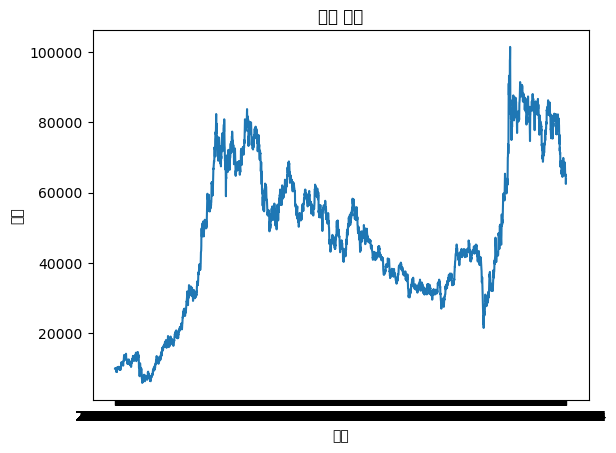

In [33]:
import matplotlib.pyplot as plt

plt.plot(df["date"],df["close"])
plt.title('기아 주가')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.show()

In [ ]:
plt.plot(df["date"],df["predict"])

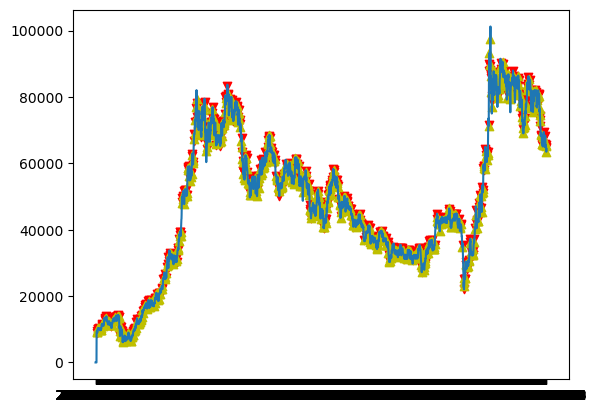

In [34]:
plt.plot(df["date"],df["predict"])
plt.scatter(signal_sell,signal_sell_predict, marker = 'v', color='r')
plt.scatter(signal_buy,signal_buy_predict, marker='^', color='y')

# train, test 분리해서 테스트


In [104]:
# 데이터 불러오기
df = pd.read_csv('./data/동화약품_sample.csv')

In [105]:
# 아예 df를 분리 - test 비중 20%
int(2698*0.2)

539

In [106]:
train_df = df[:-539]
test_df = df[-539:]

In [107]:
train_df

,code,date,open,high,low,close,diff,volume
0,20,2012-01-02,4070,4100,4060,4085,5,25451
1,20,2012-01-03,4100,4160,4100,4130,45,45291
2,20,2012-01-04,4135,4160,4125,4150,20,42911
3,20,2012-01-05,4150,4290,4110,4270,120,85140
4,20,2012-01-06,4300,4325,4220,4240,30,45535
...,...,...,...,...,...,...,...,...
2154,20,2020-10-05,22200,24350,21700,24100,2250,1094057
2155,20,2020-10-06,24100,24350,23350,23750,350,463912
2156,20,2020-10-07,23500,23550,23100,23500,250,322425
2157,20,2020-10-08,23600,24850,23600,24150,650,716608


In [108]:
# 나중에 날짜 붙여주기위해 따로 저장
train_date = pd.DataFrame(train_df['date']) 
test_date = pd.DataFrame(test_df['date'])

# 종가만 사용
train_df = pd.DataFrame(train_df['close'])
test_df = pd.DataFrame(test_df['close'])


In [109]:
# time series 데이터를 supervised learning 데이터로 변형

# 10일치의 데이터 입력하고 다음날 하루의 종가 정보 예측
days_in = 10
day_out = 1

raw = []

# 10개씩 덩어리로 자르기
for i in range(days_in, 0, -1):
    raw.append(train_df.shift(i))

for i in range(0, day_out):
    raw.append(train_df.shift(-i))

train_sum = pd.concat(raw, axis=1)
train_sum.dropna(inplace=True)

# row로는 날짜, column은 10일간의 종가들이 들어가고, 마지막 열인 11열을 타겟컬럼으로 설정



In [111]:
train = train_sum.values

In [113]:
# 모델 훈련 및 예측

# 리스트별로 맨 마지막 값이 타겟 값
X_train, y_train = train[:, :-1], train[:, -1]

model = XGBRegressor(objective='reg:squarederror', n_estimators=80)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=80, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [114]:
result_list=[]
for i in range(0,len(train)+1):
    data_in = values[i:(days_in)+i]
    result = model.predict([data_in])
    result_list.append(result)
    print('input: %s, Predicted: %.3f' % (data_in, result[0]))

input: [4085 4130 4150 4270 4240 4360 4395 4610 4585 4515], Predicted: 4486.994
input: [4130 4150 4270 4240 4360 4395 4610 4585 4515 4470], Predicted: 4624.177
input: [4150 4270 4240 4360 4395 4610 4585 4515 4470 4650], Predicted: 4589.897
input: [4270 4240 4360 4395 4610 4585 4515 4470 4650 4570], Predicted: 4559.247
input: [4240 4360 4395 4610 4585 4515 4470 4650 4570 4550], Predicted: 4588.208
input: [4360 4395 4610 4585 4515 4470 4650 4570 4550 4600], Predicted: 4625.670
input: [4395 4610 4585 4515 4470 4650 4570 4550 4600 4640], Predicted: 4730.219
input: [4610 4585 4515 4470 4650 4570 4550 4600 4640 4800], Predicted: 4754.584
input: [4585 4515 4470 4650 4570 4550 4600 4640 4800 4745], Predicted: 4820.509
input: [4515 4470 4650 4570 4550 4600 4640 4800 4745 4885], Predicted: 4893.870
input: [4470 4650 4570 4550 4600 4640 4800 4745 4885 4840], Predicted: 4818.807
input: [4650 4570 4550 4600 4640 4800 4745 4885 4840 4800], Predicted: 4805.681
input: [4570 4550 4600 4640 4800 4745 48

In [115]:
f_train_result=[]
for i in range(len(result_list)):
    value = result_list[i][0]
    f_train_result.append(value)

In [116]:
train_df['predict'] = 0
train_df['predict'][9:]=f_train_result

In [118]:
train_label=[]
for i in range(9,len(train_df)):
    if train_df['close'][i] < train_df['predict'][i]:
        train_label.append(1)
    elif train_df['close'][i] > train_df['predict'][i]:
        train_label.append(-1)
    elif train_df['close'][i] == train_df['predict'][i]:
        train_label.append(0)


In [119]:
train_df['label'] = 0
train_df['label'][9:]=train_label

C:\Users\bin\AppData\Local\Temp\ipykernel_11832\4007669686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label'][9:]=train_label


In [121]:
# 그래프 그리기 위해 날짜 다시 붙여주기
train_df['date'] = train_date

In [124]:
# 매매 시그널 생성
train_signal = []
for i in range(9,len(train_df)):
    # 첫번째 거래이고
    if i== 9:
        # up이면 buy
        if train_df['label'][i]== 1:
            train_signal.append('buy')
        # down이면 no action
        elif train_df['label'][i]== -1:
            train_signal.append('no action')
    # up -> down : sell
    elif train_df['label'][i-1] == 1 and train_df['label'][i] == -1 :
        train_signal.append('sell')
    # up -> up : holding
    elif train_df['label'][i-1] == 1 and train_df['label'][i] == 1 :
        train_signal.append('holding')
    # down -> down : no action
    elif train_df['label'][i-1] == -1 and train_df['label'][i] == -1 :
        train_signal.append('no action')
    # down -> up : buy
    elif train_df['label'][i-1] == -1 and train_df['label'][i] == 1 :
        train_signal.append('buy')
    

In [127]:
train_df['signal'] = 0
train_df['signal'][9:] = train_signal

C:\Users\bin\AppData\Local\Temp\ipykernel_11832\1298069128.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['signal'][9:] = train_signal


c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bin\anaconda3\envs\FINAL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50557 (\N{HANGUL SYLLABLE YAG}) missing from current font.
  fig.canvas.print_figu

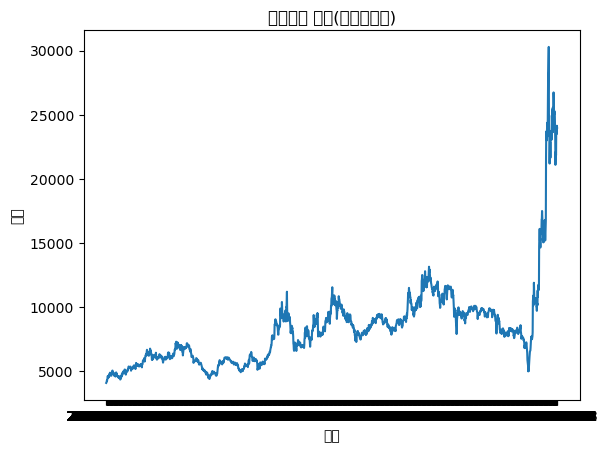

In [131]:
import matplotlib.pyplot as plt

plt.plot(train_df["date"],train_df["close"])
plt.title('동아약품 주가(훈련데이터)')
plt.xlabel('날짜')
plt.ylabel('종가')
plt.show()

In [134]:
# 매매신호 그래프에 표시하기 위해
# buy 신호 날짜 리스트, sell 신호 날짜 리스트 
train_signal_buy = []
train_signal_sell = []
train_signal_buy_predict=[]
train_signal_sell_predict=[]

for idx, signal in enumerate(train_df['signal']):
    # buy 신호
    if signal == 'buy':
        train_signal_buy.append(train_df['date'][idx])
        train_signal_buy_predict.append(train_df['predict'][idx])
    elif signal == 'sell':
        train_signal_sell.append(train_df['date'][idx])
        train_signal_sell_predict.append(train_df['predict'][idx])

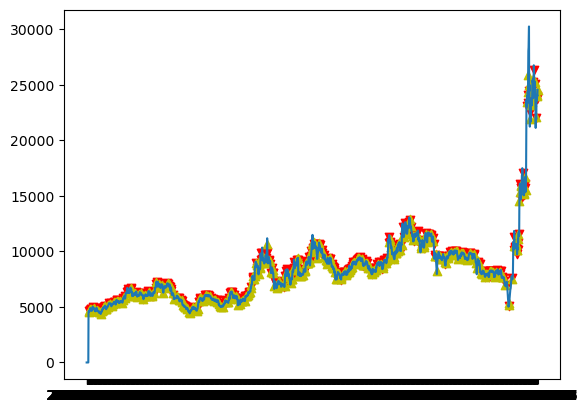

In [136]:
plt.plot(train_df["date"],train_df["predict"])
plt.scatter(train_signal_sell,train_signal_sell_predict, marker = 'v', color='r')
plt.scatter(train_signal_buy, train_signal_buy_predict, marker='^', color='y')

해야할 것
1.기업리스트 생성 코드 작성 - 매일?매번 추세 강도 강한 기업으로 선정, 추세 강도가 강한 기업으로 선정
2.
3.거래 수수료 얼마나 되는지 보고 모델 성능 판단하기
거래수수료 * 거래횟수 
모델 성능 판단 지표 : 트레이딩 성과 (승률, payoff ratio, profit factor 등)
payoff ratio : 수익 평균에서 손실 평균을 나눈 값
profit factor : 총 수익 금액을 총 손실 금액으로 나눈 값

# 기업리스트 생성 코드

기업 선정 기준 : 유망한 / 성장이 지속 가능한 기업인가 / 
앞으로 장기적인 전망이 중요한 게 아니라 앞으로 단기적으로 주가가 상승할 기업이 중요

장 시작 전 : 모든 기업(2500)의 시그널을 분석하여 가장 상승 폭이 높은 기업들 추리기
그 기업들을 매수

포트폴리오 재구성 기간 : 매일 추세(앞으로 14일간의) 판단


1.사용자 입금, 모델 선택
2.모델에 따라 자동으로 기업리스트 선정 <- aroon 추세판단으로 기업선정
((-> 모델 window size를 30으로 줘서 한달 동안의 전망 예측해서 종목 선정?))
한달동안 다 예측하고 예측값들의 추세를 보기 -> 추세가 상승세

symbol_list = ["005930","035720","000660","069500"] # 매수 희망 종목 리스트

bought_list = [] # 매수 완료된 종목 리스트

total_cash = get_balance() # 보유 현금 조회 (db에서 가져옴)
stock_dict = get_stock_balance() # 보유 주식 조회 (db에서 가져옴)

for sym in stock_dict.keys():
    bought_list.append(sym)

((유망한 기업 n개 선정)이것도 모델링으로 자동화되도록)
target_buy_count = n # 매수할 종목 수
buy_percent = 1/n # 종목당 매수 금액 비율



while문 - 자동매매 시작
1.현재 날짜 체크 
  1)토요일이나 일요일이면 자동 종료
  2)평일
    (1) 주식장 시간일 경우 : AM 09:05 ~ PM 03:15
        사용자 원금 추가 있을 경우 db에 업데이트
        for문으로 기업리스트 돌면서 행동
        -모델학습결과 테이블에서 예측값을 기반으로 한 어제의 거래 신호 가져오기
        ->ACTION
            첫 거래인 경우 : (buy/no action)
                ㄱ.buy: for 문으로 기업별 거래 신호 체크하면서 사용자 입금 잔고 0이 될 때까지 주식 매수
                -> 매수신호가 없어서 돈이 남는 경우는 hold
                ㄴ.no action
            else: buy/sell/hold/no action
                신호에 따라 행동
                

    (2) 주식장 이외의 시간
        pass?
        오늘 장 기반으로 계산된 새로운 거래 신호 가져오기
        -> 내일 행동 (buy/sell/hold/no action)



=> 거래 끝나고 17:00에 db 업데이트
기업별 시가,종가, 
모델별로 기업별 보유 주식수
모델수익(= 기업별 보유종목 * 보유주식수)
-> 모델의 수익률 (모델수익/모델원금) 
-> 사용자수익률을 모델수익률%로 계산
오늘 업데이트된 종가 기반으로 내일의 신호 생성

오전 08:50에 db 업데이트 
사용자 원금추가 내역






In [ ]:
import datetime

# 아침에 db user 조회 
# - 잔고, 운영모델, 보유 주식 조회

    
try:
    model = # <- 사용자
    total_cash = 1000000 # 
    symbol_list = ["20","21","23","24"] # 선정된 종목 4개
    target_buy_count = len(symbol_list) # 매수할 종목 수
    buy_percent = 1/(target_buy_count) # 종목당 매수 금액 비율
    bought_list = # <- 보유기업 있다면 불러오기
    soldout = False
    
    

    while True:
        t_now = datetime.datetime.now()
        t_9 = t_now.replace(hour=9, minute=0, second=0, microsecond=0)
        t_start = t_now.replace(hour=9, minute=5, second=0, microsecond=0)
        t_sell = t_now.replace(hour=15, minute=15, second=0, microsecond=0)
        t_exit = t_now.replace(hour=15, minute=20, second=0,microsecond=0)

        today = datetime.datetime.today().weekday()

        if today == 5 or today == 6:  # 토요일이나 일요일이면 자동 종료
            break

        if t_start < t_now < t_sell :  # AM 09:05 ~ PM 03:15 : 매수

            for company in symbol_list:
                
                # 각 기업별 거래 신호 체크 <- tb모델학습결과, 모델매매신호[-1]
                    # (어제 받아놓은) 신호가 매수이면, 장 열리고 시장가 조회 후 바로 구매
                        # 구매 =  toral_cash * buy_percent
                    # 신호가 매도이면
                        # 보유한 주식 있는지 확인 후, 보유 주식 있다면 오늘 종가가격으로 매도
                    # 신호가 hold, no action이면 pass

        # 17시에 db update
        if t_now == t_now.replace(hour=17, minute=0, second=0, microsecond=0):

    



except Exception as e:
    time.sleep(1)
            


In [ ]:
# 지금까진 모델 검증을 테스트데이터 셋의 x만 넣고 predict 해서 정답값(y)랑 비교하여 정확도를 보았는데
# 여기서는 

# 1일마다 예측해서 라벨링

In [77]:
# 데이터 불러오기
df = pd.read_csv('./data/동화약품_sample.csv')

In [78]:
df = df[['date', 'close']]
values = df['close'].values
df_date = pd.DataFrame(df['date'])

In [79]:
# time series 데이터를 supervised learning 데이터로 변형

# 10일치의 데이터 입력하고 다음날 하루의 종가 정보 예측
days_in = 1
day_out = 1

df = pd.DataFrame(values)
raw = []

for i in range(days_in, 0, -1):
    raw.append(df.shift(i))


In [81]:

for i in range(0, day_out):
    raw.append(df.shift(-i))

sum = pd.concat(raw, axis=1)
sum.dropna(inplace=True)

# row로는 날짜, column은 10일간의 종가들이 들어가고, 마지막 열인 11열을 타겟컬럼으로 설정

train = sum.values

In [84]:
train

array([[4085., 4130.],
       [4130., 4150.],
       [4150., 4270.],
       ...,
       [9250., 9520.],
       [9520., 9980.],
       [9980., 9890.]])

# 기술적지표 사용하여 예측

In [59]:
import talib

In [120]:
# 데이터 불러오기
df = pd.read_csv('./data/동화약품_sample.csv')

In [121]:
# Average Directional Movement Index
df['ADX'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=14)
df['aroondown'], df['aroonup'] = talib.AROON(df['high'], df['low'], timeperiod=14)
df['ARRONOSC'] = talib.AROONOSC(df['high'], df['low'], timeperiod=14)
df['BOP'] = talib.BOP(df['open'], df['high'], df['low'], df['close'])
# Commodity Channel Index
df['CCI'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=14)
# CMO - Chande Momentum Oscillator
df['CMO'] = talib.CMO(df['close'], timeperiod=14)
# Directional Movement Index(DMI) : 추세의 방향 알려주는 추세지표
df['DMX'] = talib.DX(df['high'], df['low'], df['close'], timeperiod=14)
# MFI - Money Flow Index
df['MFI'] = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=14)
# MINUS_DI - Minus Directional Indicator
df['MINUS_DI'] = talib.MINUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
# PLUS_DI - Plus Directional Indicator
df['PLUS_DI'] = talib.PLUS_DI(df['high'], df['low'], df['close'], timeperiod=14)
# PPO - Percentage Price Oscillator
df['PPO'] = talib.PPO(df['close'], fastperiod=12, slowperiod=26, matype=0)
# ROC - Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['close'], timeperiod=10)
# RSI - Relative Strength Index
df['RSI'] = talib.RSI(df['close'], timeperiod=14)
# STOCH - Stochastic
df['slowk'], df['slowd'] = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# STOCHF - Stochastic Fast
df['fastk'], df['fastd'] = talib.STOCHF(df['high'], df['low'], df['close'], fastk_period=5, fastd_period=3, fastd_matype=0)
# TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
df['TRIX'] = talib.TRIX(df['close'], timeperiod=30)
# ULTOSC - Ultimate Oscillator
df['ULTOSC'] = talib.ULTOSC(df['high'], df['low'], df['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
# WILLR - Williams' %R
df['WILLR'] = talib.WILLR(df['high'], df['low'], df['close'], timeperiod=14)


In [122]:
df.drop(['code', 'open', 'high', 'low', 'diff', 'volume'], inplace=True, axis=1)

In [129]:
# 10일치의 데이터 입력하고 다음날 하루의 종가 정보 예측
days_in = 10
day_out = 1

# df = pd.DataFrame(values)
raw = []

for i in range(days_in, 0, -1):
    raw.append(df.shift(i))

for i in range(0, day_out):
    raw.append(df.shift(-i))

sum = pd.concat(raw, axis=1)
sum
# sum.dropna(inplace=True)

# train = sum.values

,date,close,ADX,aroondown,aroonup,ARRONOSC,BOP,CCI,CMO,DMX,...,PPO,ROC,RSI,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR
0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693,2022-11-24,8970.0,14.441566,85.714286,57.142857,-28.571429,-0.428571,-86.480186,-7.271521,2.098949,...,-0.297493,2.564103,53.793753,50.328852,66.223666,21.212121,50.328852,-0.095677,52.854723,-35.616438
2694,2022-11-25,8980.0,13.783447,78.571429,50.000000,-28.571429,-0.500000,-60.090703,-6.483531,5.227895,...,-0.101168,3.006682,55.649352,35.367255,51.203929,32.258065,35.367255,-0.089031,49.598861,-28.767123
2695,2022-11-28,8770.0,13.619794,100.000000,42.857143,-57.142857,-0.928571,-115.005035,-19.805922,11.492307,...,0.194206,8.551881,64.046046,49.447327,45.047811,94.871795,49.447327,-0.081664,53.349465,-2.469136
2696,2022-11-29,8840.0,13.564670,100.000000,35.714286,-64.285714,0.388889,-104.775023,-13.977173,12.848057,...,0.720083,12.895928,73.315374,65.432175,50.082252,69.166667,65.432175,-0.072429,53.063471,-22.839506


In [124]:
sum

,date,close,ADX,aroondown,aroonup,ARRONOSC,BOP,CCI,CMO,DMX,...,PPO,ROC,RSI,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR
98,2012-05-10,5130.0,33.730721,0.000000,100.000000,100.000000,0.674419,131.712474,39.572354,52.576561,...,1.163278,-2.923977,56.024770,74.574713,60.010745,74.712644,74.574713,0.096594,48.644348,-47.154472
99,2012-05-11,5120.0,35.163959,0.000000,100.000000,100.000000,-0.100000,152.942865,37.865047,53.796045,...,0.854032,-1.953125,57.899110,77.426564,71.799088,80.555556,77.426564,0.100367,56.662174,-40.650407
100,2012-05-14,5120.0,36.896215,7.142857,100.000000,92.857143,0.136364,148.926047,37.865047,59.415545,...,0.392493,-1.367188,59.300239,79.756066,77.252448,84.000000,79.756066,0.104253,57.420034,-35.772358
101,2012-05-15,5000.0,36.847970,0.000000,92.857143,92.857143,-0.500000,20.311526,17.809166,36.220783,...,0.009083,-0.200000,55.333875,74.851852,77.344828,60.000000,74.851852,0.107809,55.492233,-45.528455
102,2012-05-16,4800.0,35.573669,0.000000,85.714286,85.714286,-0.869565,-125.203252,-6.582846,19.007761,...,-0.345967,3.958333,55.333875,66.840580,73.816166,56.521739,66.840580,0.111021,55.049676,-45.528455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693,2022-11-24,8970.0,14.441566,85.714286,57.142857,-28.571429,-0.428571,-86.480186,-7.271521,2.098949,...,-0.297493,2.564103,53.793753,50.328852,66.223666,21.212121,50.328852,-0.095677,52.854723,-35.616438
2694,2022-11-25,8980.0,13.783447,78.571429,50.000000,-28.571429,-0.500000,-60.090703,-6.483531,5.227895,...,-0.101168,3.006682,55.649352,35.367255,51.203929,32.258065,35.367255,-0.089031,49.598861,-28.767123
2695,2022-11-28,8770.0,13.619794,100.000000,42.857143,-57.142857,-0.928571,-115.005035,-19.805922,11.492307,...,0.194206,8.551881,64.046046,49.447327,45.047811,94.871795,49.447327,-0.081664,53.349465,-2.469136
2696,2022-11-29,8840.0,13.564670,100.000000,35.714286,-64.285714,0.388889,-104.775023,-13.977173,12.848057,...,0.720083,12.895928,73.315374,65.432175,50.082252,69.166667,65.432175,-0.072429,53.063471,-22.839506


In [84]:
# 모델 훈련 및 예측

X_train, y_train = train[:, :-1], train[:, -1]

model = XGBRegressor(objective='reg:squarederror', n_estimators=80)
model.fit(X_train, y_train)

data_in = values[-(days_in):]

result = model.predict([data_in])

print('input: %s, Predicted: %.3f' % (data_in, result[0])
)

input: [9220 9280 9270 9300 9280 9200 9250 9520 9980 9890], Predicted: 9804.992


In [85]:
df

,0
0,4085
1,4130
2,4150
3,4270
4,4240
...,...
2693,9200
2694,9250
2695,9520
2696,9980
